100%|██████████| 1000/1000 [00:05<00:00, 169.30it/s]


Fraction that changed category: 0.137


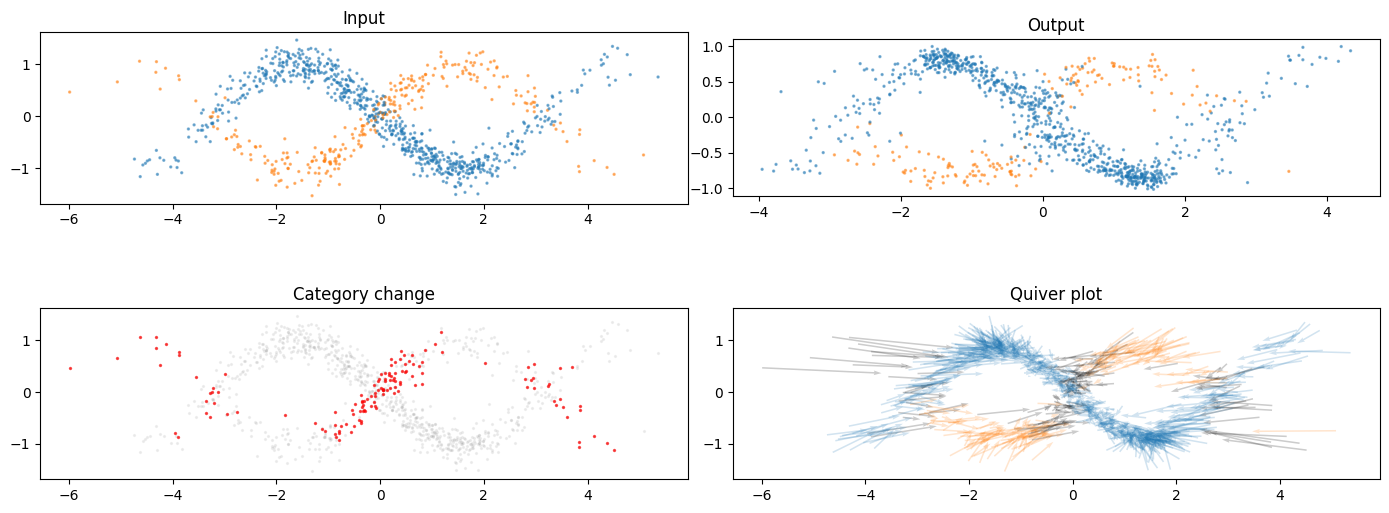

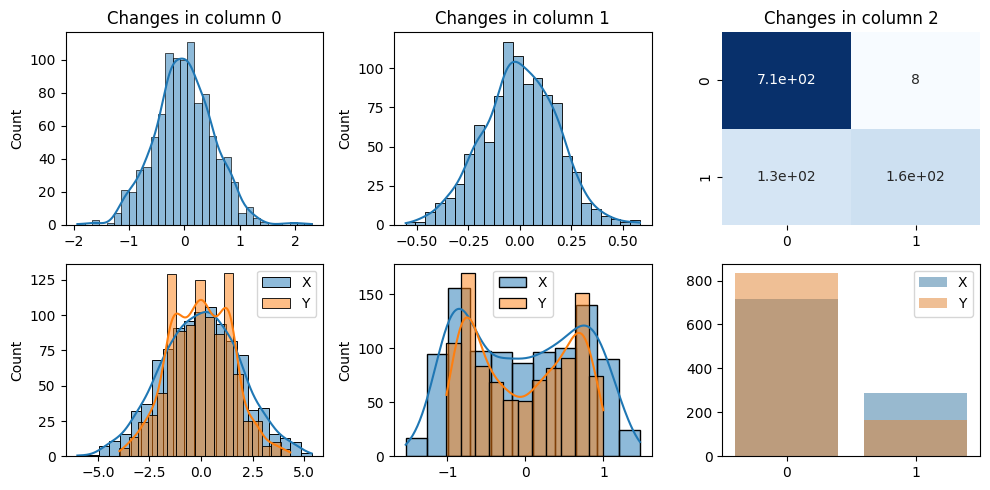

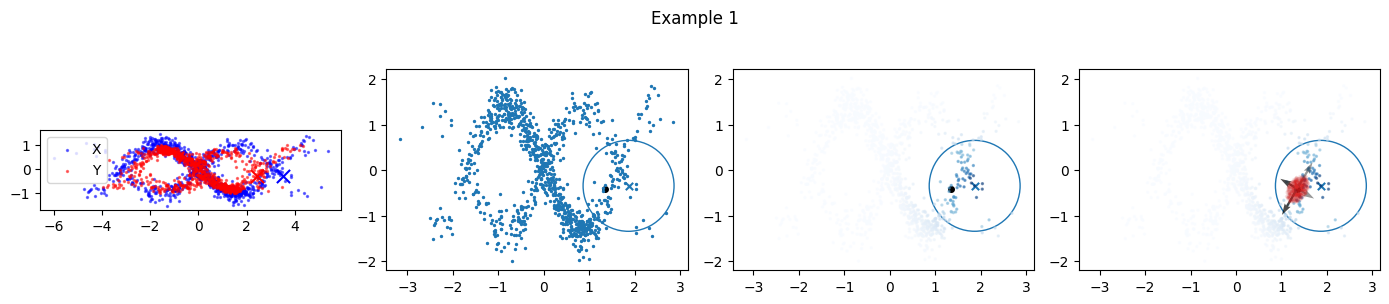

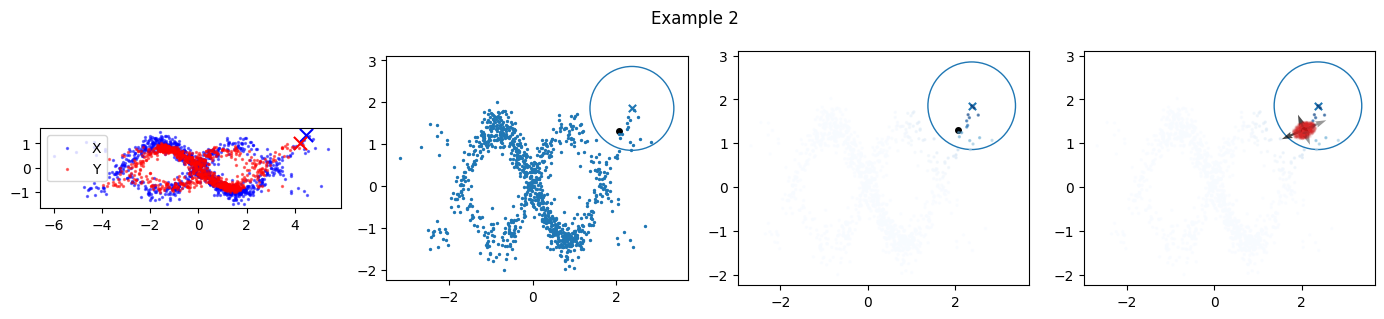

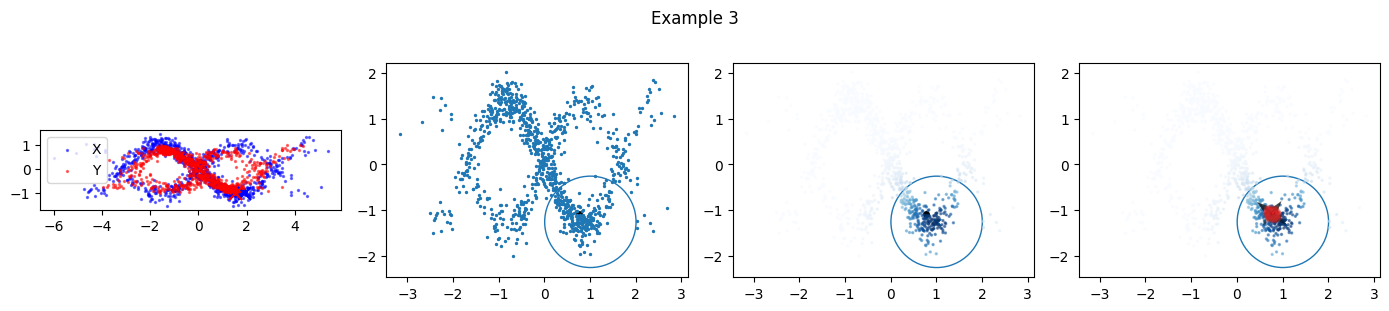

In [41]:
from collections import defaultdict
from typing import Any, Literal
import numpy as np
from scipy.spatial import KDTree, Voronoi, ConvexHull, voronoi_plot_2d
import scipy.stats
import scipy.special
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
from typing import Any, cast, Callable, Tuple, List, List as List_
import warnings
import abc
import numpy as np
import scipy.stats
import scipy.special
import matplotlib.pyplot as plt
import abc


cast_rv_continuous = lambda x: cast(scipy.stats.rv_continuous, x)


class RadialSpace:
    'Hyperspheres in R^d'

    @classmethod
    def d_volume(cls, d:int|np.ndarray, r:float|np.ndarray=1):
        'Volume enclosed by the hypersphere in d dimensions with radius r'
        return np.pi**(d/2) / scipy.special.gamma(1 + d/2) * r**d
    
    @classmethod
    def d_surface(cls, d:int|np.ndarray, r:float|np.ndarray=1):
        'Surface of the hypersphere in d dimensions with radius r, i.e. derivative of volume(r) wrt r'
        return np.pi**(d/2) / scipy.special.gamma(1 + d/2) * r**(d-1) * d
    
    
    _cache_instances = {} # class attribute to cache instances
    def __new__(cls, d:int):
        key = (cls.__name__, d)
        obj = cls._cache_instances.get(key)
        if obj is not None:
            return obj
        obj = super().__new__(cls)
        obj._init(d)
        cls._cache_instances[key] = obj
        return obj
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self.d})"

    def _init(self, d:int): # if it was called __init__, it would be called even if cached 
        assert d==round(d) and d>=1, d
        self.d = d
        'Mass of a unit hypersphere in d dimensions with constant unit density'
        self._unit_vol = self.d_volume(1)
        self._unit_surface = self.d_surface(1)
    
    def volume(self, r:float|np.ndarray=1):
        return self.d_volume(self.d, r)
    
    def surface(self, r:float|np.ndarray=1):
        return self.d_surface(self.d, r)
    
    def random_on_surface(self, r:float|np.ndarray=1, size=None):
        'Draw uniformly from the sphere surface'
        r = np.asarray(r).astype(float)
        shape = r.shape if size is None else tuple(np.ravel(size))
        X =  np.random.normal(0, 1, size=(*shape, self.d))
        X /= r * np.linalg.norm(X, axis=-1, keepdims=True)
        return X
    
    def surface_marginal_pdf(self, r:float|np.ndarray=1, d:int|None=None):
        'Draw uniformly from the sphere surface and take the first coordinate, ignoring the rest'
        r = np.asarray(r).astype(float)
        d = self.d if d is None else d
        rv = cast_rv_continuous(scipy.stats.beta((d-1)/2, (d-1)/2))
        return rv.pdf((r+1)/2) /2
    
    def alt_random_surface_marginal(self, r:float|np.ndarray=1, size=None, d=None):
        'Alternative to self.random(r, size)[:,0]'
        r = np.asarray(r).astype(float)
        d = self.d if d is None else d
        if d == 1: # (special case: Rademacher distribution)
            return (2*np.random.randint(0, 2, size=size) - 1.0)*r
        rv = cast_rv_continuous(scipy.stats.beta((d-1)/2, (d-1)/2))
        return (rv.rvs(size=size) *2 -1)*r


class IstotropicDistribution:
    '''
    The total mass is 1 = integral of norm_pdf(r) dr.
    '''
    _r_plot:float # large radius for plotting purposes


    def __init__(self, d:int, r:float=1.0):
        '''
        d: int (dimensionality)
        r: float (radial scale, default 1.0)
        '''
        assert d==round(d) and d>=1, d
        self.space = RadialSpace(d)
        self.d = d
        self.r = r
        self._r_plot = self.r*self.d**0.5*2
        self._post_init()
        self._irr0 = self.pointwise_irradiance(0)
        self.fuzzy_radius = (1/self.space.volume(1)/self._irr0)**(1/d)
    
    @classmethod
    def from_fuzzy_radius(cls, d:int, fuzzy_radius:float):
        'Create a distribution with a given fuzzy_radius'
        r = fuzzy_radius / cls(d, 1).fuzzy_radius
        # # Reminder: Alternative using scipy solver:
        # f = lambda r: cls(d, r).fuzzy_radius - fuzzy_radius
        # r = scipy.optimize.root_scalar(f, bracket=[1e-10, 1e10]).root
        obj = cls(d, r)
        assert np.isclose(obj.fuzzy_radius, fuzzy_radius), (obj.fuzzy_radius, fuzzy_radius)
        return obj

    def _post_init(self):
        pass
    
    def __repr__(self):
        return f"{self.__class__.__name__}({self.d}, r={self.r})"
    
    
    @abc.abstractmethod
    def norm_pdf(self, r:float|np.ndarray):
        'Density of |X| for X~self. (r>=0)'
        raise NotImplementedError
    
    def norm_cdf(self, r:float|np.ndarray):
        'probability mass that is enclosed in the hypersphere of radius r. (r>=0)'
        raise NotImplementedError
    
    def random(self, size=None):
        'Draw a sample from the distribution'
        X = self.space.random_on_surface(1, size=size)
        X *= self.random_norm(size)[...,None]
        return X
    
    @abc.abstractmethod
    def random_norm(self, size=None):
        raise NotImplementedError
    
    def pointwise_irradiance(self, r:float|np.ndarray):
        '''
        Equals norm_pdf(r) / space.surface(r)
        This is the "euclidean density" in the following sense:
        Fix any point x at radius r, let B(l) be the hypercube of side l centered at x.
        The pointwise_irradiance is the limit as l goes to 0 of the integral of the distribution
        over B(l) divided by the norm_cdf of l.
        '''
        r = np.where(r==0, 1e-10, r) # Correction for singularity of some rvs
        return self.norm_pdf(r) / self.space.surface(r)
    
    def fuzzy_membership(self, r:float|np.ndarray):
        # Returns a number in [0,1]
        return self.pointwise_irradiance(r) * self.fuzzy_radius
    
    def _ref_marginal(self, r:float|np.ndarray):
        'Just for plotting purposes'
        raise NotImplementedError
    
    def _ref_irradiance(self, r:float|np.ndarray) -> float|np.ndarray:
        'Just for plotting purposes'
        raise NotImplementedError
    
    def marginal_pdf(self, x:float|np.ndarray) -> float|np.ndarray:
        'Just for plotting purposes'
        raise NotImplementedError
    
    def _compute_marginal_pdf(self, x:float) -> float:
        'Explicit computation in case no formula is available'
        warnings.warn(f"May have bugs. Not tested yet!")
        f = lambda r: self.pointwise_irradiance((r**2+x**2)**0.5) * self.space.d_surface(self.d-1, r)
        return scipy.integrate.quad(f, 0, np.inf)[0]
    
    def random_marginal(self, r:float|np.ndarray=1, size=None):
        'Alternative to self.random(r, size)[:,0]'
        r = np.asarray(r).astype(float)
        return self.space.alt_random_surface_marginal(size=size) * self.random_norm(size=size)

    

class ScipyIsotropicDistribution(IstotropicDistribution):
    _rv:scipy.stats.rv_continuous

    def random_norm(self, size=None):
        return self._rv.rvs(size) * self.r

    def norm_pdf(self, r:float|np.ndarray):
        'Density for the prob. that a point chosen uniformly from the hypersphere (norm_cdf) has radius r. (r>=0)'
        return self._rv.pdf(r/self.r) / self.r
    
    def norm_cdf(self, r:float|np.ndarray):
        return self._rv.cdf(r / self.r)

    def norm_rms(self):
        return (self.r**2 * self._rv.moment(2)) ** 0.5
    
    def norm_mean(self):
        return self._rv.moment(1) * self.r


class UniformIsotropicDistribution(ScipyIsotropicDistribution):
    def _post_init(self):
        super()._post_init()
        self._rv = cast_rv_continuous(scipy.stats.beta(self.d, 1))
        self._rv_marginal = cast_rv_continuous(scipy.stats.beta((self.d+1)/2, (self.d+1)/2))
        self._r_plot = self.r*1.2
    
    def _ref_irradiance(self, r:float|np.ndarray):
        return np.where(r<self.r, 1, 0) / self.space.volume(self.r)
    
    def marginal_pdf(self, x:float|np.ndarray):
        # Reminder. This is equivalent:
        # return self.space.surface_marginal_pdf(x, d=self.d+2) / self.r
        x = np.clip(x/self.r, -1, 1)
        return self._rv_marginal.pdf((x+1)/2) / self.r / 2

    def random_marginal(self, size=None):
        # Alternative implementation
        return (self._rv_marginal.rvs(size=size) * 2 - 1)*self.r
    
    # Reminder: Random_radius alternatives:
    # Formula 1: np.random.random(size)**(1/self.d) * self.r
    # Formula 2: np.max(np.random.random((*shape, d)), axis=1) * self.r


class GaussianIsotropicDistribution(ScipyIsotropicDistribution):

    def _post_init(self):
        super()._post_init()
        self._rv = cast_rv_continuous(scipy.stats.chi(self.d))
        self._r_plot = self.r*self.d**0.5*5
    
    def random(self, size=None):
        shape = () if size is None else tuple(np.ravel(size))
        X =  np.random.normal(0, 1, size=(*shape, self.d))
        return X * self.r

    def _ref_irradiance(self, r:float|np.ndarray):
        rv = cast_rv_continuous(scipy.stats.halfnorm())
        c = 2**(self.d/2+1) / 5 * scipy.special.gamma(self.d/2)
        c *= self.space.surface(self.r)
        return rv.pdf(r/self.r)/self.r / c
    
    def marginal_pdf(self, x:float|np.ndarray):
        return scipy.stats.norm.pdf(x/self.r) / self.r


class ExponentialIsotropicDistribution(ScipyIsotropicDistribution):

    def _post_init(self):
        super()._post_init()
        self._rv = cast_rv_continuous(scipy.stats.gamma(self.d))
        self._r_plot = self.r*self.d**0.5*8

    def _ref_irradiance(self, r:float|np.ndarray):
        c = scipy.special.gamma(self.d) * self.space.surface(self.r)
        return 1 / self.r * np.exp(-r / self.r) / c
    
    def marginal_pdf(self, x:float|np.ndarray):
        # if self.d == 1: # Reminder: this code would be equivalent for d=1
        #     return np.exp(-np.abs(x)/self.r) / (2*self.r)
        d = self.d
        G = scipy.special.gamma
        c = 2**(d/2) / np.pi * G(1 + d/2) / G(1 + d)
        f = lambda x: scipy.special.kv(d/2, x) * x**(d/2)
        return c * f(np.abs(x)/self.r) / self.r

# -----------------------------

class ColumnGroup:
    scale = 1.0
    def __init__(self, scale=1.0):
        self.scale = scale

    @staticmethod
    def _pre_shape(X):
        X = np.asarray(X)
        assert len(X.shape) <= 2, X.shape
        shape = X.shape
        while len(X.shape) < 2:
            X = X[:,None]
        return X, shape
    
    def pre_post(self, X:np.ndarray) -> Tuple[np.ndarray, Callable[[np.ndarray], np.ndarray]]:
        raise NotImplementedError
    
    _Categorical:"type[ColumnGroupCategorical]"
    _Continuous:"type[ColumnGroupContinuous]"
    _Discrete:"type[ColumnGroupDiscrete]"
    List:"type[ColumnGroupList]"
    # For simplicity when creating the list:
    @classmethod
    def Cont(cls, column_idx:List_[int]|int, scale=1.0):
        return (column_idx, cls._Continuous(scale=scale))
    @classmethod
    def Disc(cls, column_idx:List_[int]|int, scale=1.0):
        return (column_idx, cls._Discrete(scale=scale))
    @classmethod
    def Cat(cls, column_idx:List_[int]|int, d:int, scale=1.0):
        return (column_idx, cls._Categorical(scale=scale, d=d))
    
    def __repr__(self):
        return f"{self.__class__.__name__}(scale={self.scale})"
    

class ColumnGroupContinuous(ColumnGroup):
    def pre_post(self, X:np.ndarray):
        X, X_shape = self._pre_shape(X)
        mu, sigma = X.mean(axis=0), X.std(axis=0)
        X = (X - mu) * (self.scale / sigma)

        def post(Y:np.ndarray):
            Y = Y * (sigma / self.scale) + mu
            return Y.reshape(X_shape)
        return X, post

class ColumnGroupDiscrete(ColumnGroup):
    def pre_post(self, X:np.ndarray):
        X, post_cont = ColumnGroupContinuous(scale=self.scale).pre_post(X) 
        uniques = np.unique(X, axis=0)
        tree = KDTree(uniques)
        
        def post(Y:np.ndarray):
            _, idx = tree.query(Y, k=1)
            Y = uniques[idx]
            return post_cont(Y)
        
        return X, post

class ColumnGroupCategorical(ColumnGroup):

    def __init__(self, d:int, scale=1.0):
        self.scale = scale
        # if d is None and auto_d is not None:
        #     d = int(auto_d.max()+1)
        self.d = d
    
    def pre_post(self, X_cat:np.ndarray):
        X_cat, X_cat_shape = self._pre_shape(X_cat)
        assert X_cat.shape[-1] == 1, X_cat.shape
        d = int(X_cat.max()+1) if self.d is None else self.d
        simplex = CategoricalSimplex(d, lin_scale=1)
        #Awful temporary fix
        side_scale = self.scale * simplex.lin_scale['radius'] / simplex.lin_scale['side']
        simplex = CategoricalSimplex(d, lin_scale=side_scale) # type:ignore
        assert simplex.lin_scale['side'] == self.scale, (simplex.lin_scale['side'], self.scale)
        X = simplex.cat_to_lin(X_cat)
        
        def post( Y:np.ndarray):
            # Rescaling commented because the argmax is unaffected with it
            return simplex.lin_to_cat(Y).reshape(X_cat_shape)
        return X, post

ColumnGroup._Categorical = ColumnGroupCategorical
ColumnGroup._Continuous = ColumnGroupContinuous
ColumnGroup._Discrete = ColumnGroupDiscrete


class ColumnGroupList(List_[Tuple[np.ndarray, ColumnGroup]]):

    def __init__(self, *groups:Tuple[List_[int]|int, ColumnGroup]):
        self[:] = [(np.ravel(idx), col_type) for (idx, col_type) in groups]
        idx = np.concatenate([np.ravel(idx) for idx, _ in self])
        assert set(idx) == set(range(len(idx))), "The continuous, categorical and discrete indices must be unique and cover all columns"
        self.d = len(idx)
        self.by_idx:List_[ColumnGroup] = []
        self.by_idx[:] = [None] * self.d # type:ignore
        for idx, col_type in self:
            for i in idx:
                self.by_idx[i] = col_type
    
    def pre_post(self, X: np.ndarray):
        X, X_shape = ColumnGroup._pre_shape(X)
        assert self.d == X.shape[1], (self.d, X.shape[1])
        X_groups = [(idx, col_type.pre_post(X[:,idx])) for idx, col_type in self]

        X_pre = np.concatenate([X_pre for _, (X_pre, _) in X_groups], axis=1)
        
        def post(Y:np.ndarray):
            out = np.ones_like(X) * np.nan
            i = 0
            for idx, (X_pre, post_) in X_groups:
                j = i+X_pre.shape[1]
                out[:, idx] = post_(Y[:, i:j])
                i = j
            assert i==Y.shape[1], (i, Y.shape[1])
            return out.reshape(X_shape)
        
        return X_pre, post

ColumnGroup.List = ColumnGroupList

class CG(ColumnGroup):
    pass

# -----------------------------



class CategoricalSimplex:
    '''
    Embedding for a categorical variable with d categories. There are three types of embeddings:
    - The "categorical space" (cat), where each category is an integer from 0 to d-1
    - The "one-hot space" (oh) or "affine space", where each category is a one-hot vector (in d-dimensions)
    - The "linear space" (lin), where each category is a point in (d-1)-dimensions
    '''

    def __init__(self,
                 n_cat:int,
                 lin_scale:float|Literal['unit_side', 'match_oh']='match_oh', 
                 oh_scale:float|Literal['unit_side', 'match_lin']=1,
                 ):
        '''
        lin_scale: float or 'unit_side' or 'match_oh'
            Radius of the simplex in the linear space.
        oh_scale: float or 'unit_side' or 'match_lin'
            Norm of the one-hot-encoded vectors in the one-hot space.
        '''
        self.n_cat = n_cat
        self.d = d = n_cat-1 # Dimensionality of the simplex

        # Default scales. Caution: side and radius scale simultaneously but not vertex_norm because of the affine map
        dt_scales = np.dtype([('vertex_norm', float), ('side', float), ('radius', float), ('factor', float)])
        Scale = lambda values, by: np.array(tuple(by*np.array(values.tolist())), dtype=dt_scales)
        s_oh = Scale(np.array([1, np.sqrt(2), np.sqrt(d/(d+1)), 1]), 1.0)
        s_lin =  Scale(np.array([1, s_oh['side']/s_oh['radius'], 1, 1]), 1.0)
        s_lin['factor'] = 1
        
        # Parse the scale arguments
        f = lambda x, ref: cast(float|None,1/ref['side'] if x =='unit_side' else None if isinstance(x,str) else x)
        _s_lin = f(lin_scale, s_lin)
        _s_oh = f(oh_scale, s_oh)
        if _s_lin is None or _s_oh is None:
            if _s_lin is not None:
                s_lin = Scale(s_lin, _s_lin)
                s_oh = Scale(s_oh, s_lin['radius'] / s_oh['radius'])
            elif _s_oh is not None:
                s_oh = Scale(s_oh, _s_oh)
                s_lin = Scale(s_lin, s_oh['radius'] / s_lin['radius'])
            else:
                raise Exception("Cannot have match_oh and match_lin simultaneously")
        else:
            s_lin = Scale(s_lin, _s_lin)
            s_oh = Scale(s_oh, _s_oh)
        self.lin_scale = s_lin
        self.oh_scale = s_oh

        V = self._simplex_vertices(d) # of radius 1.
        self.isometry = np.sqrt(d/(d+1)) * V

        self.lin_vertices = self.lin_scale['vertex_norm'] * V
        self.oh_vertices = self.oh_scale['vertex_norm'] * np.eye(d+1)
        self.oh_centroid = np.mean(self.oh_vertices, axis=0)
        self.lin_volume = np.sqrt((d+1)/2**d) / scipy.special.gamma(1+d) * self.lin_scale['side']**d
        self.oh_volume = np.sqrt((d+1)/2**d) / scipy.special.gamma(1+d) * self.oh_scale['side']**d

    @staticmethod
    def _simplex_vertices(d:int):
        # The columns of V are the vertices of the d-dimensional simplex of radius 1
        assert d > 0
        V = np.array([[-1, 1]])
        k = 2
        while k <= d:
            V_i = [([-1/k, *(np.sqrt(k**2-1)/k*u)]) for u in V.T]
            v_k = [1, *np.zeros(k-1)]
            V = np.array([v_k, *V_i]).T
            k += 1
        return V

    def _clean_cat(self, X_cat:np.ndarray):
        assert np.all(np.isclose(X_cat, X_cat.astype(int))), X_cat
        X_cat = X_cat.astype(int)
        if len(X_cat.shape)==2 and X_cat.shape[-1]==1:
            X_cat = X_cat[:,0]
        return X_cat

    def cat_to_oh(self, X_cat:np.ndarray):
        return self.oh_vertices.T[self._clean_cat(X_cat)]
    
    def cat_to_lin(self, X_cat:np.ndarray):
        return self.lin_vertices.T[self._clean_cat(X_cat)]
    
    def oh_to_cat(self, X:np.ndarray):
        return np.argmax(X, axis=-1)
    
    def lin_to_cat(self, X:np.ndarray):
        X_OH = self.lin_to_oh(X)
        return self.oh_to_cat(X_OH)

    def oh_to_lin(self, X_oh:np.ndarray):
        # X_oh has rows of one-hot vectors
        X_oh = X_oh / self.oh_scale['side']
        X_lin = np.matmul(X_oh, self.isometry.T)
        return X_lin * self.lin_scale['side']
    
    def lin_to_oh(self, X_lin:np.ndarray):
        X_lin = X_lin / self.lin_scale['side']
        X_oh = np.matmul(X_lin, self.isometry)
        return X_oh * self.oh_scale['side'] + self.oh_centroid

class NotEnoughNeighbors(Exception):
    pass


class Neighborhood:
    'Collection of possibly weighted points within a radius around a central point in R^d'

    def __init__(self, center:np.ndarray, radius:float, points:np.ndarray, weights:np.ndarray):
        self.center = center
        self.radius = radius
        self.points = points
        self.weights = weights

class Ellipsoid:
    'Ellipse in n-dimensions, defined by its center (mu), amplitudes (lambdas) and orthogonal directions (matrix V)'

    def __init__(self, mu:np.ndarray, lambdas:np.ndarray, V:np.ndarray|None=None):
        self.mu = mu
        self.lambdas = lambdas
        self.V = V if V is not None else np.eye(len(mu))
        self.d = len(lambdas)
        assert mu.shape == lambdas.shape, (mu.shape, lambdas.shape)
        assert self.V.shape == (len(mu), len(mu)), self.V.shape
        self.orientation:np.ndarray|None = None

    def orient(self, neigh:Neighborhood):
        '''
        Orient the eigenvectors towards the majority of the data points
        and assign a probability (at least 0.5) of not-inverting for random sampling
        '''
        # Project the points onto the ellipsoid to see the direction
        orientation = np.zeros(self.d)
        X = neigh.points - neigh.center
        for i in range(self.d):
            # Count the number of neighbors in the direction of the eigenvector
            dirs = X @ self.V[:,i]
            w_pos = np.sum(neigh.weights[dirs>0] * dirs[dirs>0])
            w_neg = np.sum(neigh.weights[dirs<0] * -dirs[dirs<0]) # type:ignore
            if np.isclose(w_pos + w_neg, 0):
                orientation[i] = 0.5
                continue
            orientation[i] = w_pos / (w_pos + w_neg + 1e-15)
            if orientation[i] < 0.5:
                self.V[:,i] *= -1
                orientation[i] = 1 - orientation[i]
        self.orientation = orientation
    
    
    @classmethod
    def from_neighborhood(cls, neigh:Neighborhood, forced_center=None, orient=False):
        points, weights = neigh.points, neigh.weights
        if forced_center is not None:
            # Add symmetric points to force the center
            points = np.concatenate([points, forced_center - (points-neigh.center)], axis=0)
            weights = np.concatenate([weights, weights], axis=0)

        mu = np.average(points, axis=0, weights=weights)
        cov = np.cov(points.T, aweights=weights)
        try:
            diag, V = np.linalg.eigh(cov)
        except np.linalg.LinAlgError:
            raise NotEnoughNeighbors
        diag[np.isclose(diag,0, atol=1e-15)] = 0
        lambdas = np.sqrt(diag)
        if np.all(lambdas==0):
            raise NotEnoughNeighbors
        ell = cls(mu, lambdas, V)
        if orient:
            ell.orient(neigh)
        return ell

    
    def random_hard(self, size=None):
        'Draw uniformly from the volume enclosed by the ellipsoid'
        return self.random(fuzzy=False, size=size)
    
    def random_fuzzy(self, size=None):
        'Draw from an (unbounded) multivariate gaussian distribution'
        return self.random(fuzzy=True, size=size)

    def random(self, fuzzy:bool, size=None):
        _N = 1 if size is None else int(np.prod(np.ravel(size)))
        if fuzzy:
            dist = GaussianIsotropicDistribution.from_fuzzy_radius(self.d, 1)
        else:
            dist = UniformIsotropicDistribution.from_fuzzy_radius(self.d, 1)
        X = dist.random(_N)
        X *= self.lambdas
        if self.orientation is not None:
            sign = 2*(np.random.random(size=X.shape) < self.orientation[None,:]) - 1
            X = np.abs(X) * sign
        for i in range(_N):
            X[i, :] = (self.V @ X[i, :]) + self.mu
        _size = () if size is None else tuple(np.ravel(size))
        return X.reshape((*_size, self.d))

class EllipseNeighborhoods:

    def __init__(self, X:np.ndarray, fuzzy=False):
        self.tree = KDTree(X)
        self.is_fuzzy = fuzzy
    
    def ball(self, x:np.ndarray, radius:float, min_neigh=None):
        if self.is_fuzzy:
            return self.fuzzy_ball(x, radius, min_neigh=min_neigh)
        else:
            return self.hard_ball(x, radius, min_neigh=min_neigh)

    def hard_ball(self, x:np.ndarray, radius:float, min_neigh=None):
        idx = self.tree.query_ball_point(x, r=radius, p=2)
        X = self.tree.data
        X, counts = np.unique(X[idx], axis=0, return_counts=True)
        weights = counts
        neigh = Neighborhood(x, radius, X, weights)
        ell = Ellipsoid.from_neighborhood(neigh)
        return neigh, ell

    def fuzzy_ball(self, x:np.ndarray, radius:float, min_neigh=None, alpha=0.95):
        d = len(x)
        dist = GaussianIsotropicDistribution.from_fuzzy_radius(d, radius)
        # radius *= GaussianIsotropicDistribution(d)._R
        large_radius = dist._r_plot # While I implement the ppf properly for all isotropic distributions
        # ref_dist = scipy.stats.chi(d)
        #ref_dist.ppf(alpha)
        idx = self.tree.query_ball_point(x, r=large_radius, p=2)
        X = self.tree.data
        X, counts = np.unique(X[idx], axis=0, return_counts=True)
        if len(counts)<=1 or (min_neigh is not None and np.sum(counts) < min_neigh):
            raise NotEnoughNeighbors
        weights = counts * dist.fuzzy_membership(np.linalg.norm(X-x, axis=1))
        neigh = Neighborhood(x, radius, X, weights)
        ell = Ellipsoid.from_neighborhood(neigh)
        return neigh, ell
    
    def ball_auto(self, x:np.ndarray, min_radius:float, min_neigh:int):
        f = self.fuzzy_ball if self.is_fuzzy else self.hard_ball
        r = min_radius
        while True:
            try:
                return f(x, r, min_neigh=min_neigh)
            except NotEnoughNeighbors:
                r *= 1.1

class AlgorithmParams:
    def __init__(self,
                 min_neigh_radius=0.5,
                 min_neigh_count=10,
                 min_abs_noise_radius=0.0,
                 min_rel_noise_radius=0.0,
                 noise_scale=1.0,
                 fuzzy_neigh=True,
                 fuzzy_noise=True,):
        self.min_neigh_radius = min_neigh_radius
        self.min_neigh_count = min_neigh_count
        self.min_abs_noise_radius = min_abs_noise_radius
        self.min_rel_noise_radius = min_rel_noise_radius
        self.fuzzy_neigh = fuzzy_neigh
        self.fuzzy_noise = fuzzy_noise
        self.noise_scale = noise_scale


def algorithm(X: np.ndarray, column_types:ColumnGroupList, params:AlgorithmParams, size=None):
    X, post = column_types.pre_post(X)
    N, d = X.shape
    _N = 1 if size is None else int(np.prod(np.ravel(size)))
    Y = np.ones((_N, N, d)) * np.nan
    radii_that_work = []
    # Prepare nearest neighbor search
    neighs = EllipseNeighborhoods(X, fuzzy=params.fuzzy_neigh)
    for i_x in tqdm(range(N)):
        xi = X[i_x]
        r = params.min_neigh_radius
        if i_x > 10:
            r = float(np.quantile(radii_that_work, 0.2))# speed up
        neigh, ell = neighs.ball_auto(xi, r, params.min_neigh_count)
        radii_that_work.append(neigh.radius)
        # Scale the ellipsoid for noise sampling
        ell.lambdas *= params.noise_scale
        min_noise_radius = max(params.min_abs_noise_radius, params.min_rel_noise_radius * r)
        ell.lambdas *= max(1, min_noise_radius/float(np.linalg.norm(ell.lambdas)))
        # Sample a random direction
        Y[:, i_x, :] = ell.random(fuzzy=params.fuzzy_noise, size=_N)
    # Postprocess
    Y = np.stack([post(Y[i, :,:]) for i in range(_N)], axis=0)
    _size = () if size is None else tuple(np.ravel(size))
    return Y.reshape(*_size, *Y.shape[1:])




# Data generation:
# X[:,0] and X[:,1] are continuous. X[:,2] is categorical, with 2 categories.
np.random.seed(0)
X = np.random.normal(0, 1, (1000,3))
X[:,0] = 2*X[:,0]
X[:,2] =  X[:,2] > 0.5
mask = X[:,2] == 1
X[mask,1] =  X[mask,1] * 0.2 + np.sin(X[mask,0])
mask = ~mask
X[mask,1] =  X[mask,1] * 0.2 - np.sin(X[mask,0])

# Column type definition. There can be continuous, discrete and categorical columns, and they can be grouped (optionally).
column_types = CG.List(
    CG.Cont([0, 1]), # 0 and 1 are continuous
    CG.Cat([2], scale=1/3, d=2),# 2 is categorical. Scale of 1/3 is recommended by Carlos for categorical columns.
)
params = AlgorithmParams(
    min_neigh_radius=1.0,
    noise_scale=0.5,
    fuzzy_noise=False,
)

# Run the algorithm
Y = algorithm(X, column_types, params)

print('Fraction that changed category:', np.mean(X[:,2]!=Y[:,2]))



# Make plots
def plot_changes(X:np.ndarray, Y:np.ndarray, column_types:ColumnGroupList):
    fig, axes = plt.subplots(2, X.shape[1], figsize=(10, 5))
    for i in range(X.shape[1]):
        cg = column_types.by_idx[i]
        if isinstance(cg, ColumnGroupCategorical):
            # Plot a matrix of input output counts for each category
            X_cat = X[:,i].astype(int)
            Y_cat = Y[:,i].astype(int)
            counts = np.zeros((cg.d, cg.d))
            for x, y in zip(X_cat, Y_cat):
                counts[x,y] += 1
            sns.heatmap(counts, ax=axes[0][i], annot=True, cbar=False, cmap='Blues')
            X_unique, X_counts = np.unique(X_cat, return_counts=True)
            sns.barplot(x=X_unique, y=X_counts, ax=axes[1][i], color='tab:blue', label='X', alpha=0.5)
            Y_unique, Y_counts = np.unique(Y_cat, return_counts=True)
            sns.barplot(x=Y_unique, y=Y_counts, ax=axes[1][i], color='tab:orange', label='Y', alpha=0.5)
            axes[1][i].legend()
        else:
            sns.histplot(Y[:,i]-X[:,i], ax=axes[0][i], kde=True, color='tab:blue')
            sns.histplot(X[:,i], ax=axes[1][i], kde=True, color='tab:blue', label='X', alpha=0.5)
            sns.histplot(Y[:,i], ax=axes[1][i], kde=True, color='tab:orange', label='Y', alpha=0.5)
            axes[1][i].legend()
        axes[0][i].set_title(f"Changes in column {i}")
    plt.tight_layout()
    plt.show()

def plot_cont_cont_cat(X, Y, colors:np.ndarray|None):
    '''
    Assumes continuous, continuous, categorical
    '''
    if colors is None:
        colors=np.array(plt.cm.tab10.colors)# type:ignore
    fig, axes = plt.subplots(2, 2, figsize=(14, 6))
    axes = np.ravel(axes)
    axes[0].scatter(*X[:,:2].T, label='X', c=colors[X[:,2].astype(int)], s=2, alpha=0.5)
    axes[0].set_title('Input')
    axes[0].set_aspect('equal')
    axes[1].scatter(*Y[:,:2].T, label='Y', c=colors[Y[:,2].astype(int)], s=2, alpha=0.5)
    axes[1].set_title('Output')
    axes[1].set_aspect('equal')
    axes[2].scatter(X[:,0], X[:,1], alpha=0.1, s=2, color='gray')
    axes[2].scatter(*X[X[:,2] != Y[:,2], 0:2].T, alpha=0.6, s=2, color='red')
    axes[2].set_title('Category change')
    axes[2].set_aspect('equal')
    axes[3].quiver(*X[:,:2].T, *(Y[:,:2]-X[:,:2]).T, scale=1, scale_units='xy', alpha=0.2, color=np.where(Y[:,2]!=X[:,2], 'black', colors[X[:,2].astype(int)]))
    axes[3].set_title('Quiver plot')
    axes[3].set_aspect('equal')
    plt.tight_layout()
    plt.show()


def algorithm_plot(X: np.ndarray, column_types:CG.List, params:AlgorithmParams, i_x=None, xy=[0,1], axes=None):
    global Xc, Yi
    X, post = column_types.pre_post(X)
    Xc = X
    N, d = X.shape
    # Prepare nearest neighbor search
    neighs = EllipseNeighborhoods(X, fuzzy=params.fuzzy_neigh)
    xi = X[i_x]
    r = params.min_neigh_radius
    neigh, ell = neighs.ball_auto(xi, r, params.min_neigh_count)
    # Scale the ellipsoid for noise sampling
    ell.lambdas *= params.noise_scale
    min_noise_radius = max(params.min_abs_noise_radius, params.min_rel_noise_radius * r)
    ell.lambdas *= max(1, min_noise_radius/float(np.linalg.norm(ell.lambdas)))
    # Sample a random direction
    y = ell.random(fuzzy=params.fuzzy_noise)
    # Sample many for better plotting
    N_samples = 1000
    Yi = ell.random(fuzzy=params.fuzzy_noise, size=N_samples)
    y_mean = np.mean(Yi, axis=0)
    
    def subset_plot(ax:"plt.Axes", show=[]): # type:ignore
        r = neigh.radius
        Nx = neigh.points
        Nxw = neigh.weights
        x = ell.mu
        V = ell.V
        lambdas = ell.lambdas / params.noise_scale
        features = {k:True for k in show}
        if features.get('xi'):
            ax.scatter(xi[None,0], xi[None,1], marker='x', s=28, color='tab:blue')
        if features.get('x'):
            ax.scatter(x[None,0], x[None,1], marker='o', s=16, color='black')
        if features.get('X'):
            ax.scatter(X[:,0], X[:,1], label='X', s=2, color='tab:blue')
        if features.get('circle'):
            circle = plt.Circle(xi, r, fill=False, color='tab:blue') # type: ignore
            ax.add_artist(circle)
            circle_xy = np.random.normal(0, 1, (100,2)) * r
            circle_xy /= np.linalg.norm(circle_xy, axis=1)[:,None]
            circle_xy += xi[None,[0,1]]
            ax.scatter(*circle_xy.T, alpha=0, marker='.', s=2, color='gray')
        if features.get('Nx'):
            ax.scatter(Nx[:,0], Nx[:,1], c=Nxw, vmin=0, label='X', s=2, marker='o', cmap='Blues', alpha=0.5)# type:ignore
        # if features.get('Nxi'):
        #     ax.scatter(xi[0]+Nxi[:,0], xi[1]+Nxi[:,1], label='X', s=5, marker='o', color='tab:blue')
        if features.get('V'):
            for i_v in range(d):
                u = V[:, i_v] * lambdas[i_v]
                ax.quiver(*x[:2], *u[:2], scale=1, scale_units='xy', color='black', alpha=0.7, linewidths=0.5)
                ax.quiver(*x[:2], *-u[:2], scale=1, scale_units='xy', color='black', alpha=0.4, linewidths=0.5)
        if features.get('Yi'):
            ax.scatter(Yi[:,0], Yi[:,1], s=2, c='tab:red', alpha=0.05) 
            # xx = np.zeros_like(Y)
            # xx[:] = x[None,:]
            # ax.quiver(*xx.T, *(Y-x[None,:]).T, scale=1, scale_units='xy', color='tab:red', alpha=0.2)
        if features.get('Yi_contour'):
            kw:Any = dict(fill=False, alpha=0.9, levels=5, linewidths=0.5)
            sns.kdeplot(data=pd.DataFrame(Y), x=0, y=1, ax=ax, color='tab:red', **kw)
        if features.get('y'):
            ax.quiver(*x[:2], *(y-x)[:2],  scale=1, scale_units='xy', color='tab:red', alpha=1)
        if features.get('y_mean'):
            ax.quiver(*x[:2], *(y_mean-x)[:2],  scale=1, scale_units='xy', color='tab:purple', alpha=1)
        ax.set_aspect('equal')
        return

    if axes is None:
        fig, axes = plt.subplots(2, 3, figsize=(5, 5))
        axes = axes.flatten()
    subset_plot(axes[0], show='X xi x circle'.split())
    subset_plot(axes[1], show='xi x circle Nx'.split())
    # axes[1].set_xlim(axes[0].get_xlim())
    subset_plot(axes[2], show='xi x circle Nx V Yi y'.split())
    return

def plot_cont_cont_examples(X, Y, idx, column_types, params):
    for i_x in idx:
        fig, axes = plt.subplots(1, 4, figsize=(14, 3))
        axes = axes.flatten()
        axes[0].set_aspect('equal')
        axes[0].scatter(X[:,0], X[:,1], label='X', s=2, c='blue', alpha=0.5)
        axes[0].scatter(Y[:,0], Y[:,1], label='Y', s=2, c='red', alpha=0.5)
        axes[0].scatter(X[[i_x],0], X[[i_x],1], marker='x', s=90, c='blue')
        axes[0].scatter(Y[[i_x],0], Y[[i_x],1], marker='x', s=90, c='red')
        axes[0].legend()
        axes[1].set_aspect('equal')
        algorithm_plot(X, column_types, params, i_x=i_x, xy=[0,2], axes=axes[1:])
        plt.suptitle(f"Example {i_x+1}")
        plt.tight_layout()
        plt.show()

colors = np.array(['tab:blue', 'tab:orange', 'tab:red'])
plot_cont_cont_cat(X, Y, colors)

plot_changes(X, Y, column_types)

plot_cont_cont_examples(X, Y, [0, 1, 2], column_types, params)


  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:04<00:00, 210.85it/s]


Fraction that changed category: 0.186


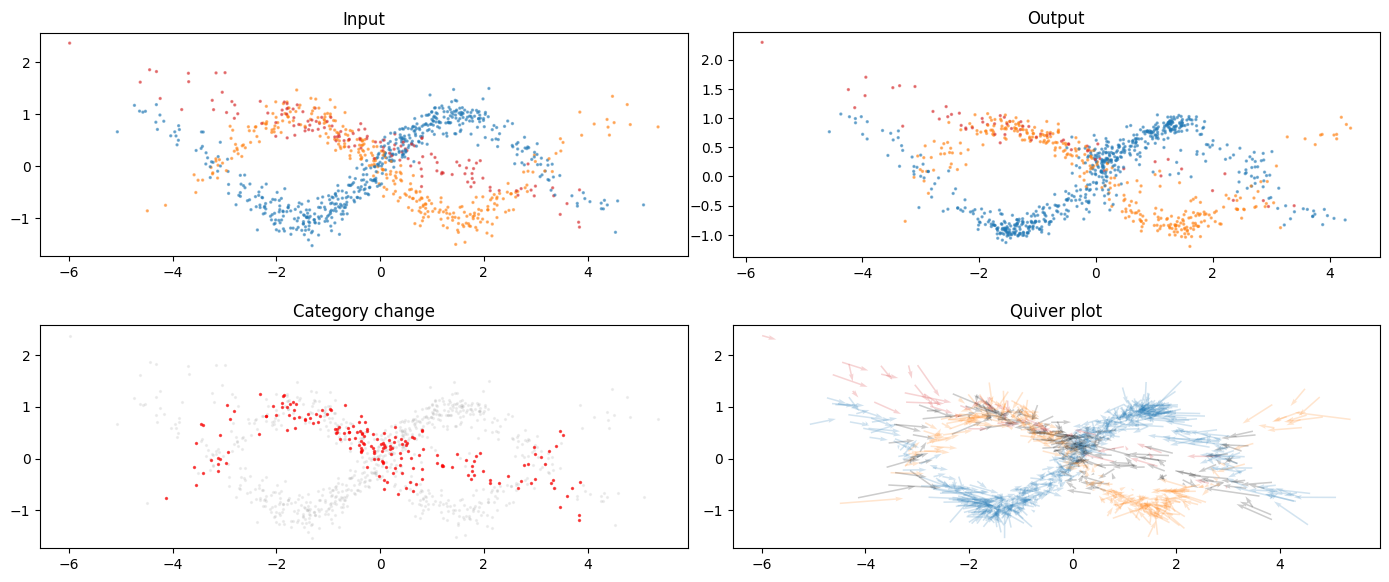

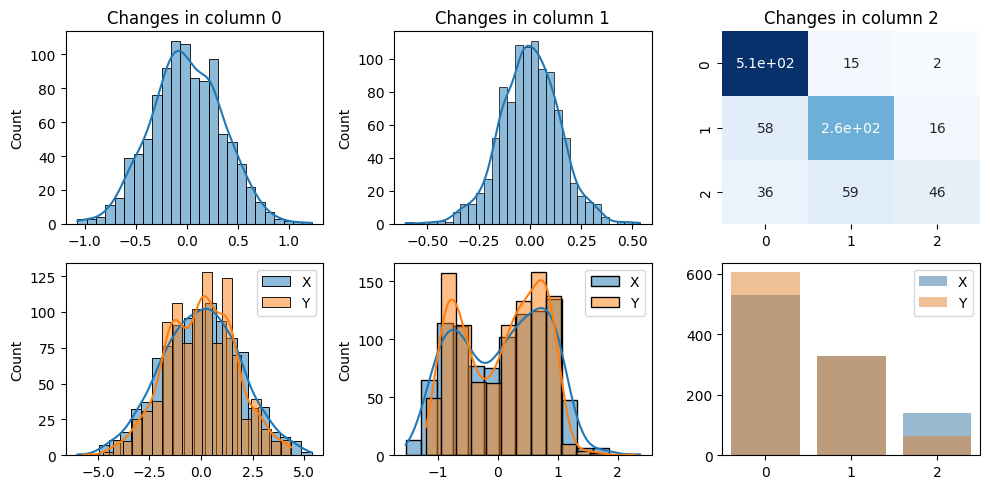

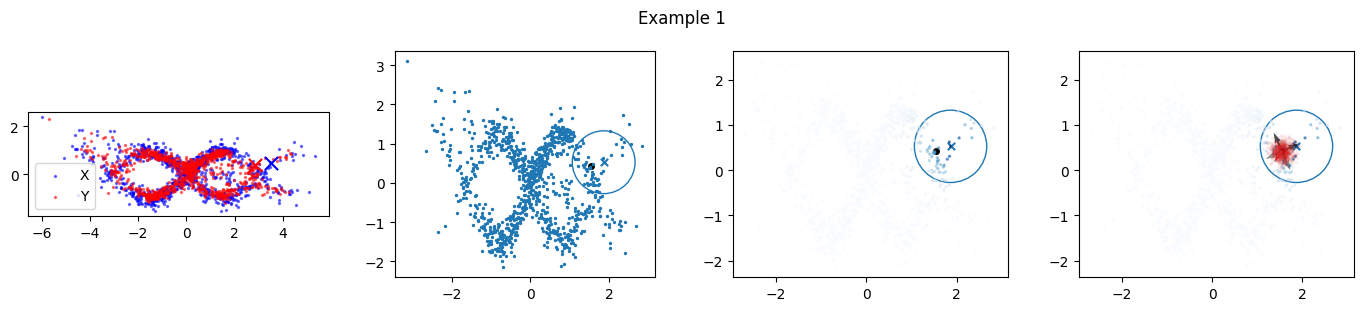

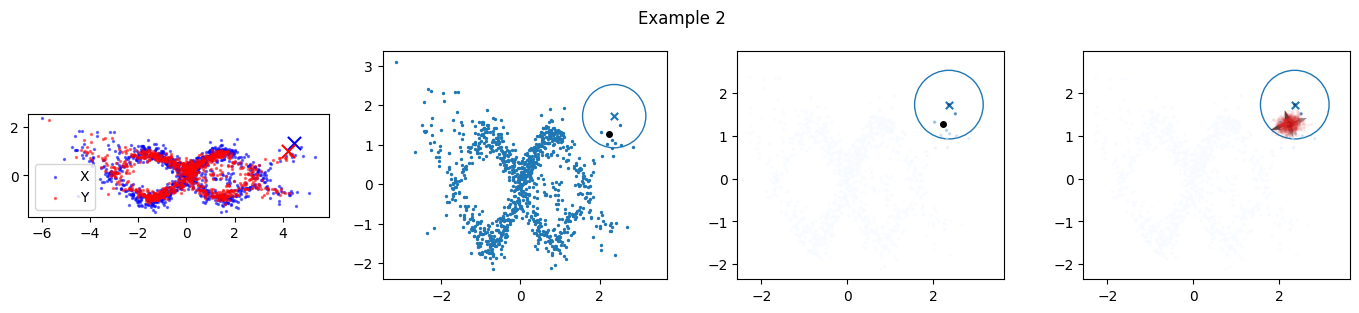

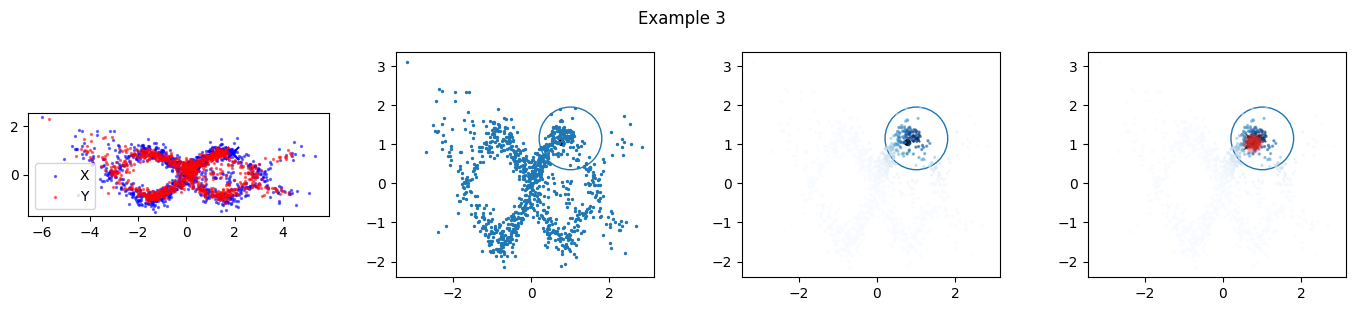

In [44]:

# Data generation. Now with 3 categories:
np.random.seed(0)
X = np.random.normal(0, 1, (1000,3))
X[:,0] = 2*X[:,0]
X[:,2] = np.abs(1.5*X[:,2]).astype(int) % 3
mask = X[:,2] == 0
X[mask,1] =  X[mask,1] * 0.2 + np.sin(X[mask,0])
mask = X[:,2] == 1
X[mask,1] =  X[mask,1] * 0.2 - np.sin(X[mask,0])
mask = X[:,2] == 2
X[mask,1] =  X[mask,1] * 0.2 - 0.3 * X[mask,0] + 0.4

# Column type definition. There can be continuous, discrete and categorical columns, and they can be grouped (optionally).
column_types = CG.List(
    CG.Cont([0, 1]), # columns 0 and 1 are continuous
    CG.Cat([2], scale=1/3, d=3),# 2 is categorical. Scale of 1/3 is recommended by Carlos for categorical columns.
)
params = AlgorithmParams(
    min_neigh_radius=0.8,
    noise_scale=0.5,
    fuzzy_noise=True,
)

# Run the algorithm
Y = algorithm(X, column_types, params)

print('Fraction that changed category:', np.mean(X[:,2]!=Y[:,2]))

plot_cont_cont_cat(X, Y, colors)
plot_changes(X, Y, column_types)
plot_cont_cont_examples(X, Y, [0, 1, 2], column_types, params)

In [ ]:

# np.random.seed(0)
# X = np.random.normal(0, 1, (500,3))
# X[:,0] = 2*X[:,0]
# X[:,2] =  X[:,2] > 0.5
# mask = X[:,2] == 1
# X[mask,1] =  X[mask,1] * 0.1 + np.sin(X[mask,0])
# mask = ~mask
# X[mask,1] =  X[mask,1] * 0.1 - np.sin(X[mask,0])
# column_types = CG.List(
#     CG.Cont([0,1]),
#     CG.Cat([2], scale=0.02, d=2),
# )
# Y = algorithm(X, column_types)
# print(np.mean(X[:,2]!=Y[:,2]))


# for i_x in range(1):
#     fig, axes = plt.subplots(1, 2, figsize=(16, 3))
#     axes = axes.flatten()
#     axes[0].set_aspect('equal')
#     axes[1].set_aspect('equal')
#     axes[0].scatter(X[X[:,2]==0,0], X[X[:,2]==0,1], label='X|0', s=2)
#     axes[0].scatter(X[X[:,2]==1,0], X[X[:,2]==1,1], label='X|1', s=2)
#     axes[1].scatter(Y[Y[:,2]==0,0], Y[Y[:,2]==0,1], label='Y|0', s=2)
#     axes[1].scatter(Y[Y[:,2]==1,0], Y[Y[:,2]==1,1], label='Y|1', s=2)
#     axes[0].legend()
#     axes[1].legend()
#     # algorithm_plot(Xc, i_x=i_x, axes=axes[1:])
#     plt.suptitle(f"Example {i_x+1}")
#     plt.tight_layout()
#     plt.show()

np.random.seed(0)
X = np.random.normal(0, 1, (1000,3))
X[:,0] = 2*X[:,0]
X[:,2] =  X[:,2] > 0.5
mask = X[:,2] == 1
X[mask,1] =  X[mask,1] * 0.2 + np.sin(X[mask,0])
mask = ~mask
X[mask,1] =  X[mask,1] * 0.2 - np.sin(X[mask,0])
column_types = CG.List(
    CG.Cont([0,1]),
    CG.Cat([2], scale=0.1, d=2),
)
params =  AlgorithmParams(min_neigh_radius=0.3, min_neigh_count=10, noise_scale=1, fuzzy_noise=True)
Y = algorithm(X, column_types, params)
print(np.mean(X[:,2]!=Y[:,2]))

N,d = X.shape

min_neigh_count = N**(1/(d+1))
min_neigh_radius = 0.3
for i_x in range(3):
    fig, axes = plt.subplots(1, 4, figsize=(14, 3))
    axes = axes.flatten()
    axes[0].set_aspect('equal')
    axes[0].scatter(X[:,0], X[:,1], label='X', s=2)
    axes[0].scatter(Y[:,0], Y[:,1], label='Y', s=2, c='red')
    axes[0].scatter(X[[i_x],0], X[[i_x],1], marker='x', s=20, c='tab:blue')
    axes[0].scatter(Y[[i_x],0], Y[[i_x],1], marker='x', s=20, c='red')
    axes[0].legend()
    algorithm_plot(X, column_types, params, i_x=i_x, xy=[0,2], axes=axes[1:])
    plt.suptitle(f"Example {i_x+1}")
    plt.tight_layout()
    plt.show()

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:00<00:00, 225.33it/s]


0.13


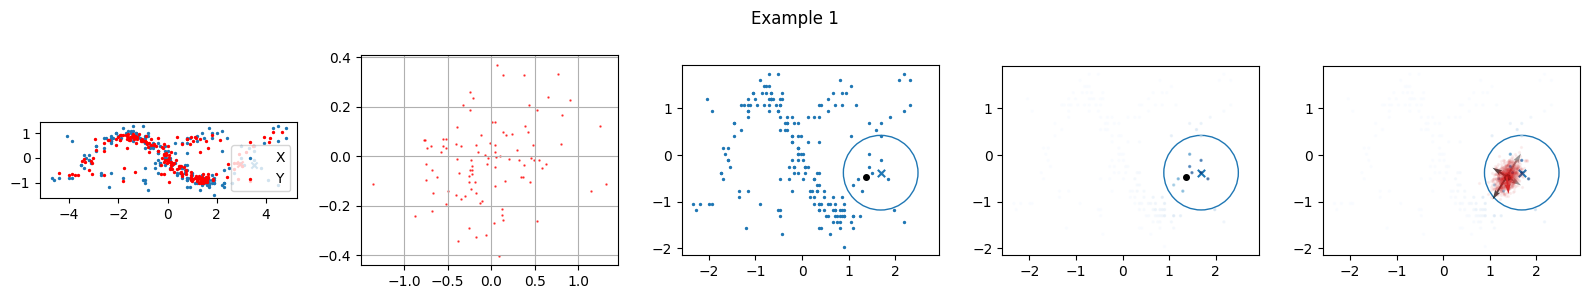

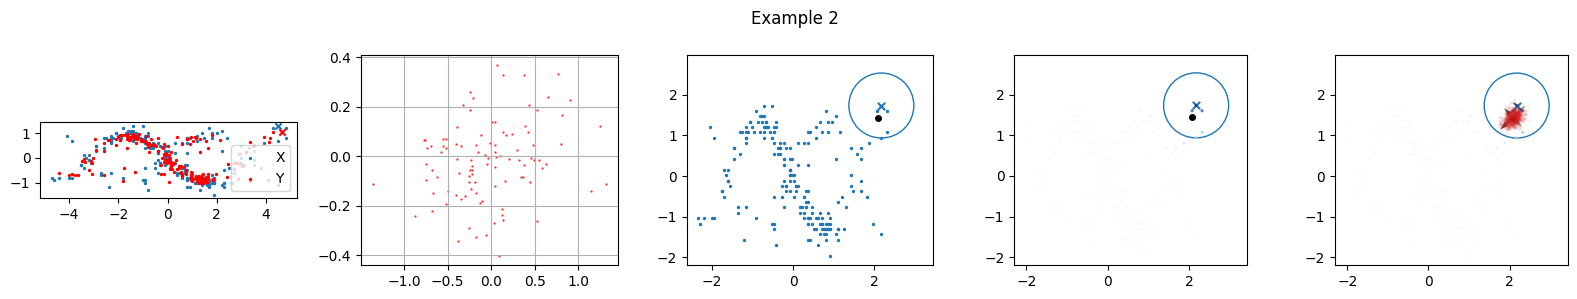

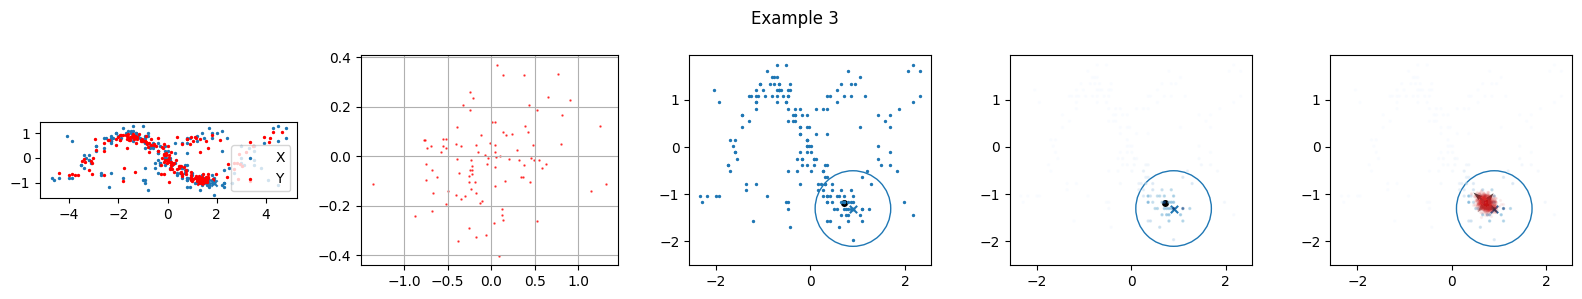

In [48]:

np.random.seed(0)
X = np.random.normal(0, 1, (200,3))
X[:,0] = 2*X[:,0]
X[:,2] =  X[:,2] > 0.5
mask = X[:,2] == 1
X[mask,1] =  X[mask,1] * 0.2 + np.sin(X[mask,0])
mask = ~mask
X[mask,1] =  X[mask,1] * 0.2 - np.sin(X[mask,0])
column_types = CG.List(
    CG.Cont([0,1]),
    CG.Cat([2], scale=0.1, d=2),
)
X[:, :2] = np.round(X[:, :2], 1)
Y = algorithm(X, column_types, params)
print(np.mean(X[:,2]!=Y[:,2]))

N,d =X.shape

min_neigh_count = N**(1/(d+1))
min_neigh_radius = 0.3
for i_x in range(3):
    fig, axes = plt.subplots(1, 5, figsize=(16, 3))
    axes = axes.flatten()
    axes[0].set_aspect('equal')
    axes[0].scatter(X[:,0], X[:,1], label='X', s=2)
    axes[0].scatter(Y[:,0], Y[:,1], label='Y', s=2, c='red')
    axes[0].scatter(X[[i_x],0], X[[i_x],1], marker='x', s=20, c='tab:blue')
    axes[0].scatter(Y[[i_x],0], Y[[i_x],1], marker='x', s=20, c='red')
    axes[0].legend()
    # axes[1].set_aspect('equal')
    # axes[1].quiver(*0*X[:100,:2].T, *(Y-X)[:100, :2].T, color='red', scale_units='xy', scale=1, alpha=0.7)
    axes[1].scatter(*(Y-X)[:100, :2].T, color='red', marker='.', s=2, alpha=0.7)
    axes[1].grid()
    
    algorithm_plot(X, column_types, params, i_x=i_x, xy=[1,2], axes=axes[2:])
    plt.suptitle(f"Example {i_x+1}")
    plt.tight_layout()
    plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:02<00:00, 236.00it/s]


0.116


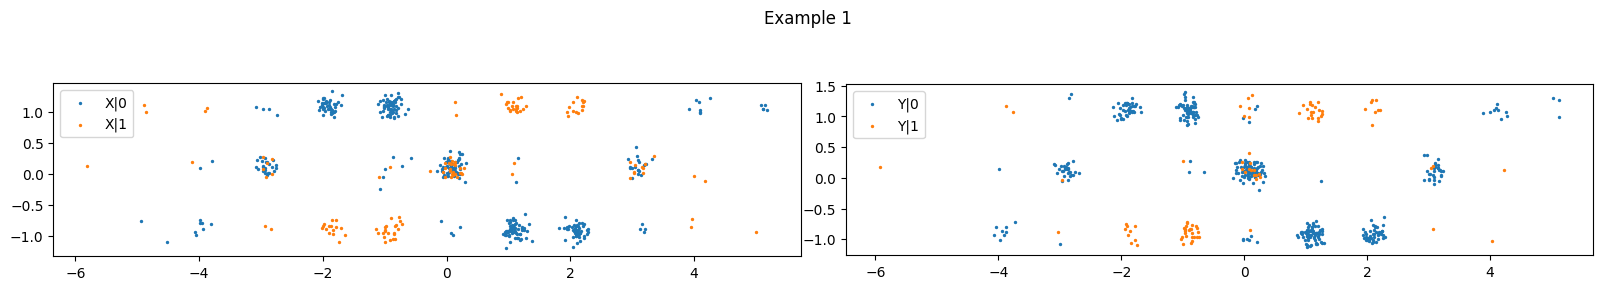

In [45]:

# fig, axes = plt.subplots(1, 2, figsize=(16, 3))
# axes = axes.flatten()
# axes[0].set_aspect('equal')
# axes[1].set_aspect('equal')
# axes[0].scatter(Xc[X[:,2]==0,0], Xc[X[:,2]==0,1], label='Xc|0', s=2)
# axes[0].scatter(Xc[X[:,2]==1,0], Xc[X[:,2]==1,1], label='Xc|1', s=2)
# plt.show()

np.random.seed(0)
X = np.random.normal(0, 1, (500,3))
X[:,0] = 2*X[:,0]
X[:,2] =  X[:,2] > 0.5
mask = X[:,2] == 1
X[mask,1] =  X[mask,1] * 0.1 + np.sin(X[mask,0])
mask = ~mask
X[mask,1] =  X[mask,1] * 0.1 - np.sin(X[mask,0])
X = np.round(X)
X[:,:2] += 0.1
column_types = CG.List(CG.Cat(2, scale=1/3), CG.Disc([0,1]))
Y = algorithm(X, column_types, params)
print(np.mean(X[:,2]!=Y[:,2]))

for i_x in range(1):
    fig, axes = plt.subplots(1, 2, figsize=(16, 3))
    axes = axes.flatten()
    axes[0].set_aspect('equal')
    axes[1].set_aspect('equal')
    noisy = lambda X: X+np.random.normal(0,1,X.shape)*1e-1
    axes[0].scatter(noisy(X[X[:,2]==0,0]), noisy(X[X[:,2]==0,1]), label='X|0', s=2)
    axes[0].scatter(noisy(X[X[:,2]==1,0]), noisy(X[X[:,2]==1,1]), label='X|1', s=2)
    axes[1].scatter(noisy(Y[Y[:,2]==0,0]), noisy(Y[Y[:,2]==0,1]), label='Y|0', s=2)
    axes[1].scatter(noisy(Y[Y[:,2]==1,0]), noisy(Y[Y[:,2]==1,1]), label='Y|1', s=2)
    axes[0].legend()
    axes[1].legend()
    # algorithm_plot(Xc, i_x=i_x, axes=axes[1:])
    plt.suptitle(f"Example {i_x+1}")
    plt.tight_layout()
    plt.show()


In [ ]:

# If I set the scale to 0.1, there appear complex matrices in the covariance